In [22]:
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
import struct
import glob
import cv2
import mxnet as mx
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from IPython.display import display, Image
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

TRAIN_DIR = 'train/'
TEST_DIR = 'test_stg1/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 300  #720
COLS = 300 #1280
CHANNELS = 3


In [2]:
url = 'https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/download'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.zip', 872167582 )
test_filename = maybe_download('test_stg1.zip', 242205616)

('Found and verified', 'train.zip')
('Found and verified', 'test_stg1.zip')


In [3]:
# Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labelled A through J.
num_classes = 8
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    zip_file = zipfile.ZipFile.open(filename)
    sys.stdout.flush()
    zip_file.extractall()
    zip_file.close()
    
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
 # if len(data_folders) != num_classes:
 #   raise Exception(
 #     'Expected %d folders, one per class. Found %d instead.' % (
#num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train = maybe_extract(train_filename)
test_stg1 = maybe_extract(test_filename)

train already present - Skipping extraction of train.zip.
['train/ALB', 'train/BET', 'train/DOL', 'train/LAG', 'train/NoF', 'train/OTHER', 'train/SHARK', 'train/YFT']
test_stg1 already present - Skipping extraction of test_stg1.zip.
[]


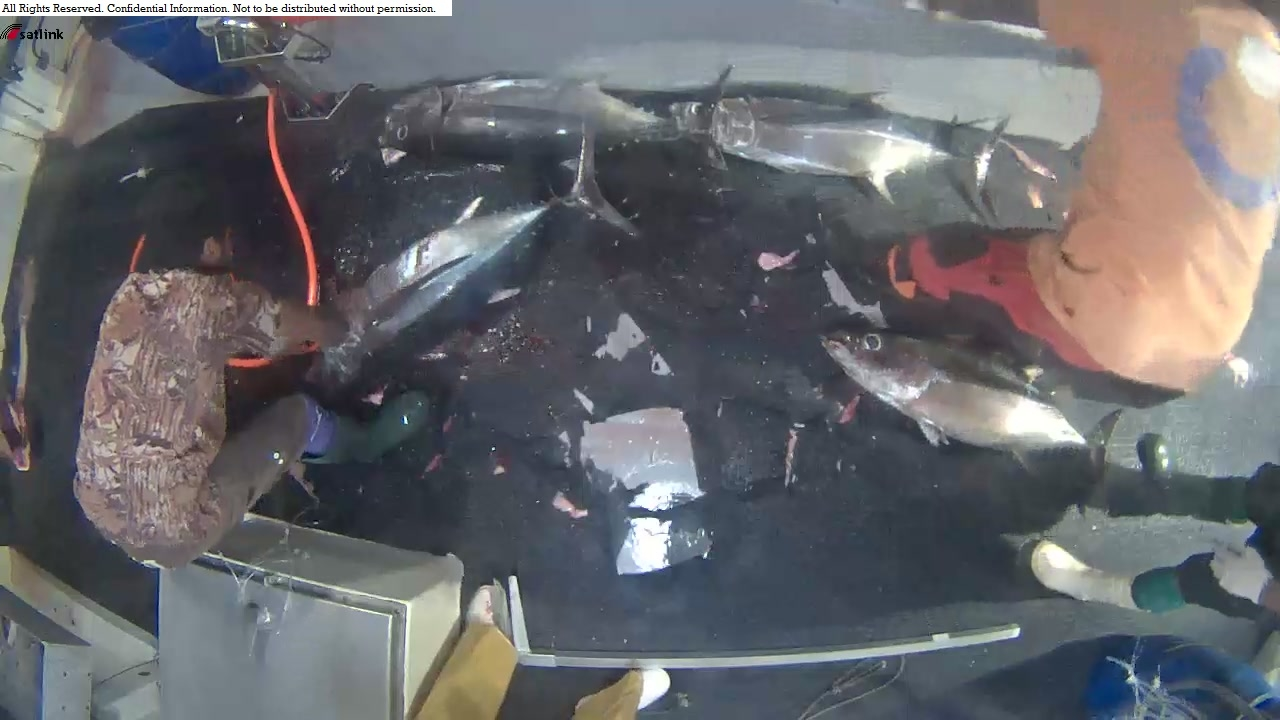

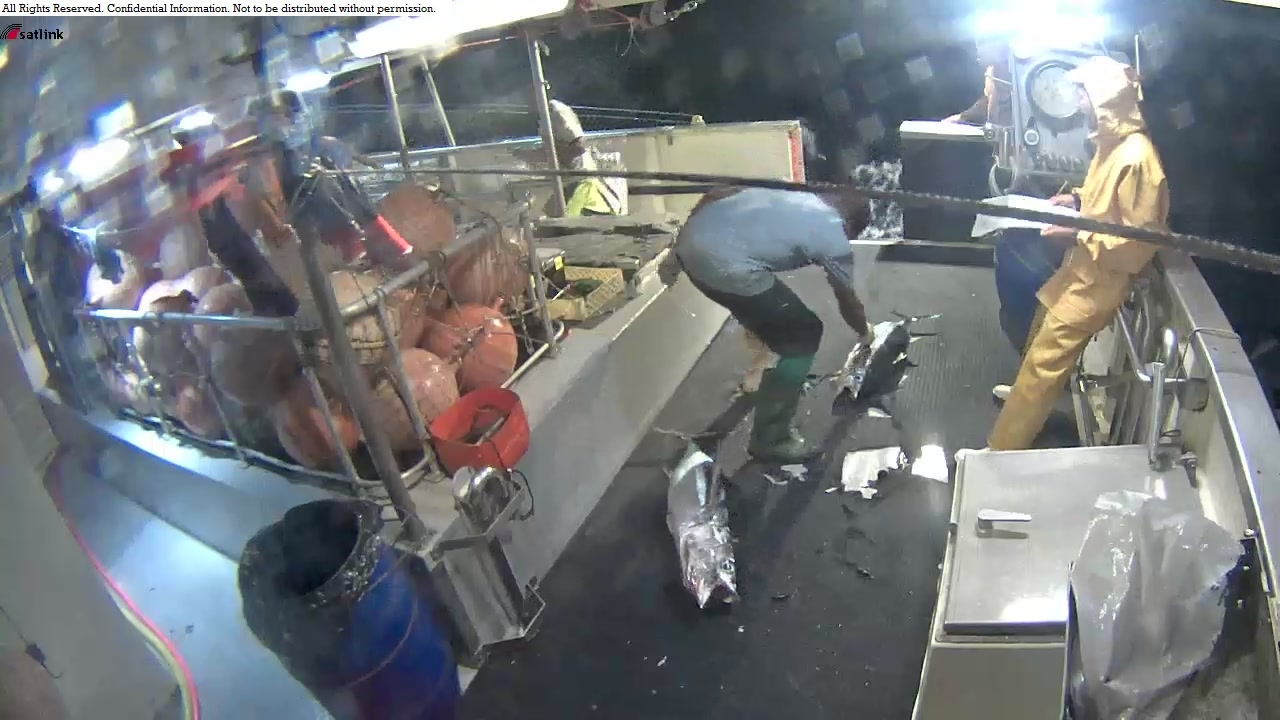

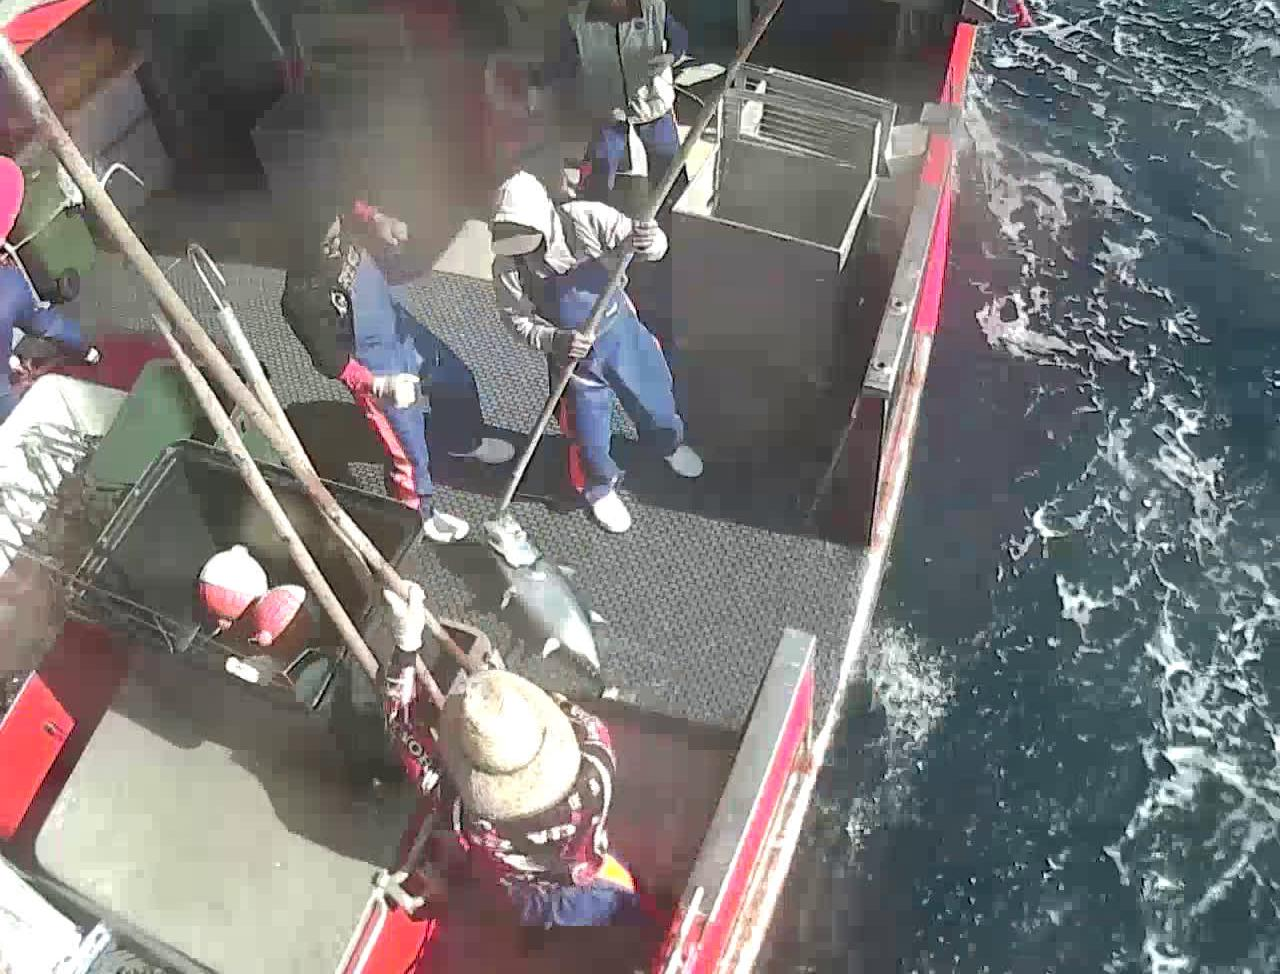

In [4]:
# displaying a few images from the dataset
display(Image(filename="train/ALB/img_00003.jpg"))
display(Image(filename="train/ALB/img_00010.jpg"))
display(Image(filename="train/ALB/img_00012.jpg"))

In [5]:
def get_images(fish):
    #Load files from train folder
    fish_dir = TRAIN_DIR + '{}'.format(fish)
    #print "printing fish dir: ", fish_dir
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images
    

In [6]:
def read_image(image):
    img = cv2.imread(image)
    #print "Image shape:", img.shape
    img = cv2.resize(img, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    #print "Image shape after rezise:", img.shape
    img = img.reshape(3, ROWS, COLS)
    #print "Image shape after reshape:", img.shape

    return img

#read_image('train/ALB/img_02913.jpg')

In [7]:
files = []
y_all = []

for fish in FISH_CLASSES:
    # Creating a list of fish files
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    # Creating a list of target fish classes
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)

y_all = np.array(y_all)
#print "list of image files:", files
#print " list of fish labels:", y_all

In [8]:
# Creating a numpy array of all fish images with shape 
X_all = np.ndarray((len(files), CHANNELS, ROWS, COLS), dtype=np.uint8)

for i, im in enumerate(files): 
    X_all[i] = read_image(TRAIN_DIR+im)
    #if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print X_all.shape

(3777, 3, 300, 300)


In [9]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
print "y_labels:", y_all

# Split into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)
print "X_train shape:", X_train.shape
print "X_valid shape:", X_valid.shape
print "y_train shape:", y_train.shape
print "y_valid shape:", y_valid.shape




y_labels: [0 0 0 ..., 7 7 7]
X_train shape: (3022, 3, 300, 300)
X_valid shape: (755, 3, 300, 300)
y_train shape: (3022,)
y_valid shape: (755,)


In [10]:
#  Creating data iterators for mxnet
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_valid, y_valid, batch_size)

In [11]:
# Defining CNN layers

# Create a placeholder for input data
data = mx.symbol.Variable('data')

# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))

# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")

# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)

# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
#mx.viz.plot_network(symbol=lenet, shape=shape)


In [12]:
# CNN model train and test
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 


In [16]:
prob = model.predict(val_iter)
print prob

[[  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]
 [  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]
 [  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]
 ..., 
 [  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]
 [  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]
 [  1.51179860e-10   2.43335757e-16   2.18416899e-02 ...,   6.55330718e-03
    5.40095861e-08   5.51264314e-08]]


In [13]:
valid_acc = model.score(val_iter)
print 'Validation accuracy: %f%%' % (valid_acc *100,)
assert model.score(val_iter) > 0.01, "Low validation accuracy."

Validation accuracy: 12.500000%


In [19]:
test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), CHANNELS, ROWS, COLS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test)